<h1 style="font-family:verdana;"> <center>Gravitational Waves:  Data Augmentation</center> </h1>

***

In this tutorial, we will see how data augmentation: a technique to increase the diversity of our training set by applying random (but realistic) transformations, such as Horizontal flipping, Vertical flipping, and Vertical shifting.

## Import Libraries

In [1]:

import pandas as pd
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style = 'darkgrid')
sns.set_palette('plasma')
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
## Read files
## Base path
BASE_DIR = "/kaggle/input/g2net-detecting-continuous-gravitational-waves/"

## Train Path
train_path = os.path.join(BASE_DIR, 'train/')
test_path = os.path.join(BASE_DIR, 'test/')

files = [f for f in os.listdir(train_path) if f.endswith('.hdf5')]
files.sort()
files[:5]

['001121a05.hdf5',
 '004f23b2d.hdf5',
 '00a6db666.hdf5',
 '00f36a6ac.hdf5',
 '010a387db.hdf5']

Here, we have printed the names of the first five files' datasets. Here, the dataset and filename without the extension are the same.

### Import Train Labels Csv file

In [3]:
## Read train_labels.csv file in BASE_DIR
labels_df = pd.read_csv(os.path.join(BASE_DIR, 'train_labels.csv'))
labels_df.head()

,id,target
0,001121a05,1
1,004f23b2d,1
2,00a6db666,1
3,00f36a6ac,1
4,010a387db,1


## Frequency of labels in training data

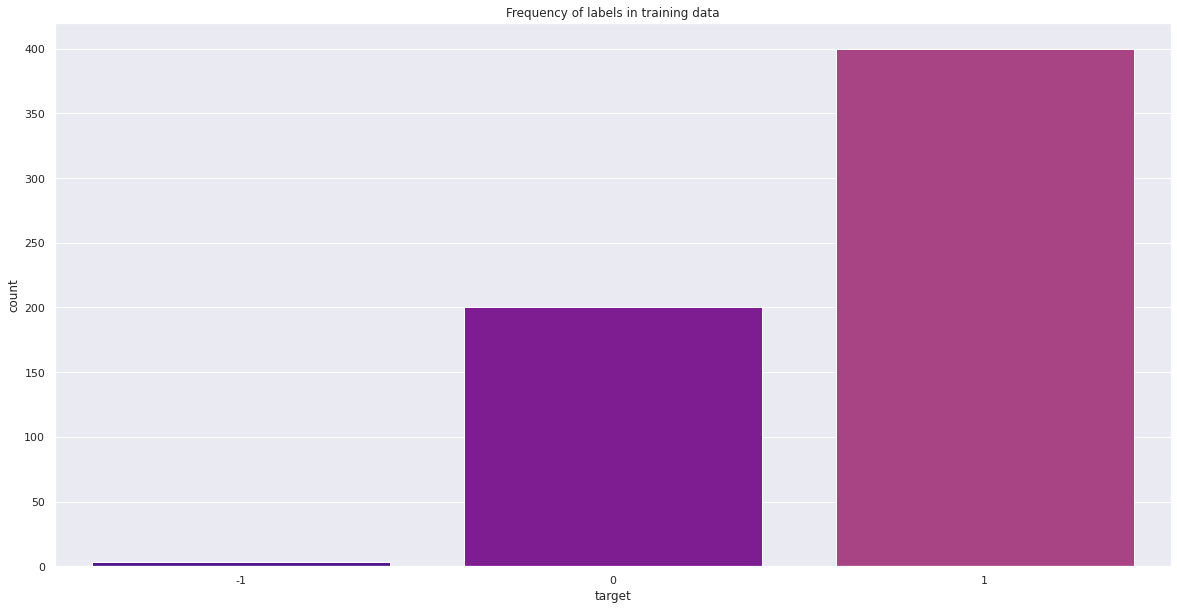

In [4]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.countplot(data=labels_df, x="target", ax=ax).set_title("Frequency of labels in training data")
## Save figure
plt.savefig('frequency_of_labels.png')
plt.show()

In [5]:
## Selecting the first file
filepath = train_path + files[0]

Here, the data is kept in HDF5 files. Large, complicated, heterogeneous data can be stored in the open-source file format known as Hierarchical Data Format version 5 (HDF5). You can organize data using the "file directory,"-like the structure of HDF5.

Only the two primary sorts of the object are included in the file structure of HDF5:

 - Datasets are multidimensional arrays of a specific type.
 - Datasets and other groups can be stored in group structures called groups.
The nexus format package allows us to see the data's organizational structure.

We are utilizing the h5py module, a lightweight Python wrapper around HDF5, to fast load our data.

In [6]:
# Read the file
f = h5py.File(filepath, 'r')
fid = list(f.keys())[0]
g = f[fid]


A series of Fourier transforms of a windowed signal make up the short-time Fourier transform (STFT). When a signal's frequency components change over time, the STFT gives time-localized frequency information, whereas the conventional Fourier transform provides frequency information averaged across the whole signal time interval.

In [7]:
# access sfts of H1
sfts = g['H1']['SFTs'][:]
print("Shape of SFTs: ", sfts.shape)
print(sfts)

Shape of SFTs:  (360, 4612)
[[-2.01780108e-24+1.70660666e-22j -1.46458433e-23+9.64213830e-23j
   1.39103851e-23-4.39236616e-23j ... -1.71771812e-23+1.28372925e-22j
   1.38921069e-22-8.29776722e-23j  7.27295802e-23+4.45595750e-23j]
 [-1.87113869e-22+1.00735020e-22j -1.51093962e-22+9.36745661e-24j
   5.01929822e-23-5.20982517e-23j ... -5.97221222e-23-1.09045934e-22j
   8.07383990e-23+1.61488764e-22j  1.47601404e-22+1.07951260e-22j]
 [-1.90160601e-22+1.52689834e-22j  1.05964946e-22+6.50407170e-23j
   1.29634017e-22+5.38747570e-23j ... -1.53258975e-22-5.96231233e-23j
  -6.09477406e-23+2.81030404e-23j -3.27759715e-23-6.07620238e-23j]
 ...
 [-8.01955113e-23+5.76858513e-23j  2.17070893e-22+1.22597858e-22j
  -1.94681547e-23-5.32914921e-23j ... -1.04928606e-23+3.23708883e-23j
   1.36459952e-23+4.76253567e-23j -5.76766263e-24-1.29746023e-22j]
 [ 1.49911681e-22-7.36853073e-23j  1.17350406e-22+1.99666867e-22j
  -1.16330023e-22-1.47523521e-23j ... -4.64647940e-23+3.71537551e-23j
   7.94444904e-23+1

It can be seen that this data file contains 360 occurrences of H1's SFTs that were collected over a period of 4612 timestamps. The numpy array contains complex numbers in each of its instances.

Note: The number of timestamp ranges in various data files may vary.

### Data Transformation

This section explains how to read SFT data from an HDF5 file and convert it into a numpy array (or SFT picture) and its associated label so that it can be applied to our task. The process is as follows:

 1) A Python class called SFT2Img is made to clean and query the dataset.
 
 2) SFTs have the following shape: ( 360,n) with n > 4000 for roughly every SFT.
 
 3) Due to the complexity of the SFTs, we developed a new NumPy array that contains the squared magnitude of the complex numbers. Additionally, we normalize the new array by dividing it by the mean of the magnitudes.
 
 4) Every SFT will have its 4096 columns reduced to 128, utilising tensor operations to lessen dimensionality.

In [8]:
class SFT2Img:
    def __init__(self, labels):
        # labels the dataframe of train labels
        self.labels = labels
    
    def __getitem__(self, index):
        # get the file id from dataframe
        lab = self.labels.iloc[index]
        file_id = lab["id"]
        
        # this is our label
        y = np.float32(lab["target"])
        
        # SFT tensor for H1 and L1 observatory (128 columns)
        img = np.empty((2, 360, 128), dtype=np.float32)
        
        filename = f"{file_id}.hdf5"
        with h5py.File(train_path + filename, 'r') as f:
            group = f[file_id]
            
            for i, obs in enumerate(['H1', 'L1']):
                # scaling the fourier transforms (complex64 in nature)
                sft = group[obs]['SFTs'][:, :4096] * 1e22
                
                # magnitude squared
                mag = sft.real ** 2 + sft.imag ** 2
                
                # normalize and reduce 4096 to 128
                mag /= np.mean(mag)
                mag = np.mean(mag.reshape(360, 128, 32), axis=2)
                
                # 0 for H1 and 1 for L1
                img[i] = mag
        
        return img, y

Here, we transformed the 2D tensor of shape (360, 4096) into a 3D tensor of shape (360, 128, 32). The third dimension's mean values were then used to replace a specific cell.

In [9]:
dataset = SFT2Img(labels_df)

image, lab = dataset[1]

print("Shape of the image: ", image.shape)

Shape of the image:  (2, 360, 128)


## Data Augmentation

In [10]:
# Function for data augmentation (flip / shift)
def augment(image, hflip=False, vflip=False, vshift=0):
    """
    Params
    
    image: np.array(2, 360, 128): Apply the transformation to this image
    vflip: Boolean for vertical flip
    hflip: Boolean for horizontal flip
    vshift: Shift amount in the vertical direction
    """
    new_img = image.copy()
    
    if hflip:
        new_img[0] = np.fliplr(new_img[0])
        new_img[1] = np.fliplr(new_img[1])
        
    if vflip:
        new_img[0] = np.flipud(new_img[0])
        new_img[1] = np.flipud(new_img[1])
    
    if isinstance(vshift, int):
        if vshift != 0:
            new_img[0] = np.roll(new_img[0], vshift, axis=0)
            new_img[1] = np.roll(new_img[1], vshift, axis=0)
    if not isinstance(vshift, int):
        print("Error: vshift expects an int or tuple of ints")
        return
        
    return new_img

In [11]:
imgdata = []
labeldata = []

for i in range(16):
    sftimg, lab = dataset[i]
    imgdata.append(sftimg)
    labeldata.append(lab)

In [12]:
eg = imgdata[4]
eg_label = labeldata[4]

print("Original SFT data: ")
print(eg)

aug_eg = augment(eg, hflip=True, vshift=100)

print("\nTransformed SFT data: ")
print(aug_eg)

Original SFT data: 
[[[0.7438407  0.78947884 1.0825088  ... 1.0621173  0.80359685 1.0240974 ]
  [1.2831509  1.1153771  1.1104574  ... 1.1111934  0.899326   0.8595428 ]
  [0.72015184 1.0749614  0.67137414 ... 1.0318413  0.82588947 1.1298972 ]
  ...
  [0.8103     0.90322536 1.015907   ... 1.10696    1.0230026  1.0432541 ]
  [0.79003775 1.0977557  0.994569   ... 0.91142863 1.1183186  1.1929452 ]
  [1.0174439  0.7592287  1.055271   ... 1.0752363  0.9949299  0.772082  ]]

 [[1.332205   0.9754716  1.248572   ... 1.0519835  0.7574228  1.1067127 ]
  [1.0744449  0.86234367 1.0001379  ... 0.81016165 0.9867332  0.9326836 ]
  [0.82821876 1.1071     0.9626672  ... 1.2898703  1.1525681  0.9440689 ]
  ...
  [0.7535117  0.9140695  0.97909874 ... 0.94200534 1.1274543  0.7212542 ]
  [0.9318824  0.7657161  1.1311576  ... 0.94865274 0.7864491  1.3298115 ]
  [0.9007108  0.8379113  1.3886341  ... 0.9787071  1.005956   0.733216  ]]]

Transformed SFT data: 
[[[0.8917476  0.8604903  1.0546235  ... 0.8755211  1

Here, we've combined two operations to create a new augmented image: horizontal flipping and vertical shifting by 100 units.

## Visualizing Augmentaed Image

Original						Augmented


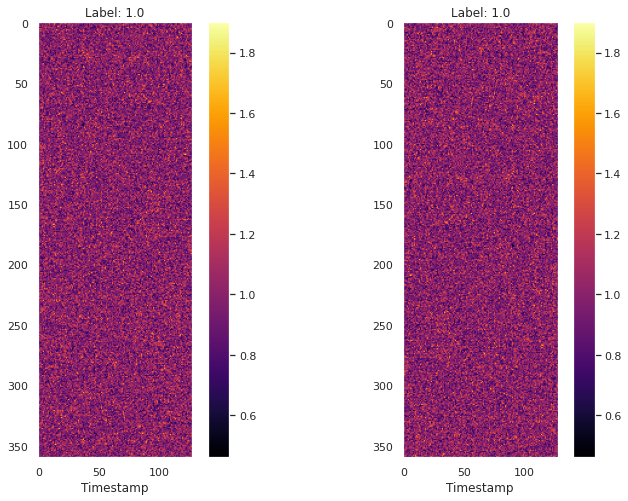

In [13]:
fig1, ax1 = plt.subplots(1, 2, figsize=(12, 8))

print("Original\t\t\t\t\t\tAugmented")

ax1[0].set_title(f"Label: {eg_label}")
p = ax1[0].imshow(eg[0, 0:360], cmap="inferno")
fig.colorbar(p, ax=ax1[0])
ax1[0].set_xlabel("Timestamp")
ax1[0].grid(False)

ax1[1].set_title(f"Label: {eg_label}")
p = ax1[1].imshow(aug_eg[0, 0:360], cmap="inferno")
fig.colorbar(p, ax=ax1[1])
ax1[1].set_xlabel("Timestamp")
ax1[1].grid(False)
## Save figure
plt.savefig('augmented_sft.png')
plt.show()


## References
 - [G2Net: Data and Augmentation](https://www.kaggle.com/code/maharshipandya/g2net-data-and-augmentation)
 - [G2Net Basic Audio Data Augmentation](https://www.kaggle.com/code/myso1987/g2net-basic-audio-data-augmentation)

## End of the Notebook